In [142]:
import finesse
import numpy as np
import matplotlib.pyplot as plt
finesse.configure(plotting=True)

## Michelson model

<img src="images/michelson.svg" width="400"/>

In [143]:
base = finesse.Model()
base.parse(
    """
    
    # Add a Laser named l1 with a power of 1 W.
    l l1 P=1M

    # Space attaching l1 <-> m1 with length of 1 m (default).
    s s1 l1.p1 bs1.p1 L=1
    
    # Beam splitter
    bs bs1 R=0.5 T=0.5 alpha=45
    
    # other two spaces
    s s2 bs1.p3 mX.p1 L=4000
    s s3 bs1.p2 mY.p1 L=4000
    
    # End mirrors
    m mX R=1 T=0 phi=0
    m mY R=1 T=0 phi=90.006
    
    """
)

In [144]:
michelson = base.deepcopy()
michelson.parse(
    """
    # Power detectors on reflection and transmission.
    pd pout bs1.p4.o
    xaxis(mX.phi, lin, 0, 360, 361)
    """
)

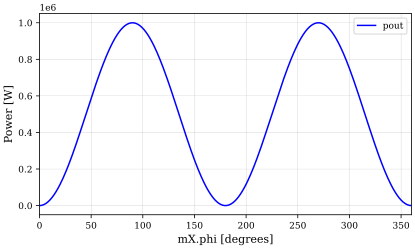

In [145]:
out = michelson.run()
out.plot();

## Response to gravitational waves

In [146]:
michelson = base.deepcopy()
michelson.parse(
    """
    fsig(1)
    sgen armx s2.h 1 0
    sgen army s3.h 1 180
    pd1 pout bs1.p4.o f=fsig.f
    # Sweep the frequency of the amplitude modulation
    xaxis(fsig.f, log, 1, 1e5, 2000)
    """
)

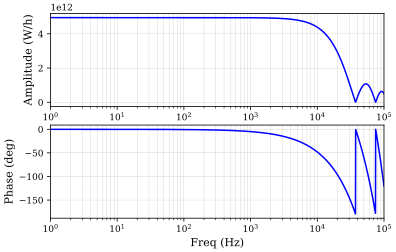

In [147]:
out = michelson.run()
H_s = abs(out["pout"])
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
ax1.semilogx(out.x[0], abs(out["pout"]))
ax2.semilogx(out.x[0], np.angle(out["pout"],deg=True))
ax1.set_ylabel('Amplitude (W/h)')
ax2.set_ylabel('Phase (deg)')
ax2.set_xlabel('Freq (Hz)')
plt.show()

#### Questions:
- What does this transfer function tell about the detector's sensitivity to low and high frequency gravitational waves?
- The magnitude of the transfer function drops off as we go to higher frequencies, why?

## Sensitivity of gravitational wave detectors

### quantum noise

In [148]:
ifo = base.deepcopy()
ifo.parse(
    """
    fsig(1)
    qshot shot_noise bs1.p4.o
    qnoised sqzd_noise bs1.p4.o
    # Sweep the frequency of the amplitude modulation
    xaxis(fsig.f, log, 1, 1e4, 2000)
    """
)

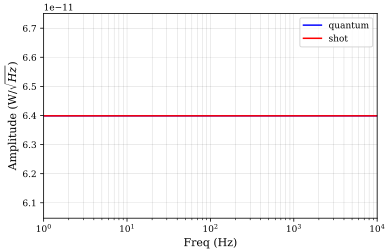

In [149]:
out = ifo.run()
plt.semilogx(out.x[0], abs(out["sqzd_noise"]),label='quantum')
plt.semilogx(out.x[0], abs(out["shot_noise"]),label='shot')
plt.ylabel('Amplitude (W/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.show()

In [150]:
ifo = base.deepcopy()
ifo.parse(
    """
    free_mass mX_sus mX.mech mass=40
    free_mass mY_sus mY.mech mass=40
    fsig(1)
    qshot shot_noise bs1.p4.o
    qnoised sqzd_noise bs1.p4.o
    # Sweep the frequency of the amplitude modulation
    xaxis(fsig.f, log, 1, 1e4, 2000)
    """
)

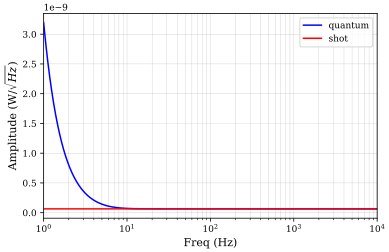

In [151]:
out = ifo.run()
plt.semilogx(out.x[0], abs(out["sqzd_noise"]),label='quantum')
plt.semilogx(out.x[0], abs(out["shot_noise"]),label='shot')
plt.ylabel('Amplitude (W/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.show()

## sensitivity TFs

For a noise source characterized by the noise spectral density $N_s$, the equivalent strain amplitude spectral density $S_s$ is given by

$$S_s(f) = \frac{N_s(f) |H_n(f)|}{|H_s(f)|}$$

where $H_n(f)$ is the transfer function from the corresponding noise to the output detector, and $H_s(f)$ is the transfer function of the gravitational wave signal to the output of the detector. The value $S_s$ tells us how much a particular noise appears to look like a gravitational wave signal, thus limits our sensitivity. For example for mirror motion due to seismic noise, the units of this work out as:

$$\frac{[m/\sqrt{Hz}] [W/m]}{[W/h]} = \frac{h}{\sqrt{Hz}}$$

For quantum nosie above, we acqually get $N_s(f) |H_n(f)|$, we to get the GW sensitivity we just have to divided by $H_s$ which is calculated above.


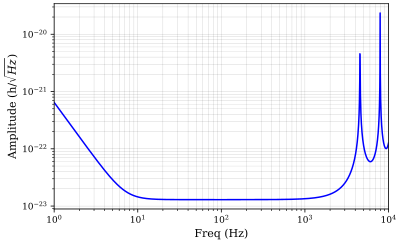

In [152]:
quantum = abs(out["sqzd_noise"])/H_s
shot = abs(out["shot_noise"])/H_s
freq = out.x[0]
plt.loglog(freq, quantum)
plt.ylabel('Amplitude (h/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.show()

## seismic noise

In [153]:
ifo = base.deepcopy()
ifo.parse(
    """
    free_mass mX_sus mX.mech mass=40
    free_mass mY_sus mY.mech mass=40
    fsig(1)
    sgen sig1 mX.mech.z 1 0
    pd1 seism_tf bs1.p4.o f=fsig.f
    xaxis(fsig.f, log, 1, 1e4, 2000)
    """
)

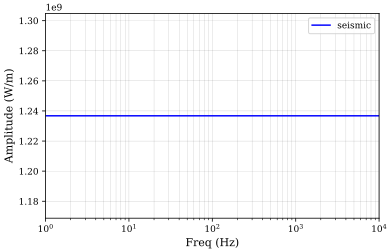

In [154]:
out = ifo.run()
seismic_tf = abs(out["seism_tf"])
plt.semilogx(out.x[0], abs(out["seism_tf"]),label='seismic')
plt.ylabel('Amplitude (W/m)')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.show()

In [155]:
def seismic_noise_ASD(f):
    f = np.array(f)
    N = 1e-4/np.abs(np.random.normal(f**15, 0, size=f.size))
    return N

N_s = seismic_noise_ASD(freq)
seismic = N_s * seismic_tf / H_s

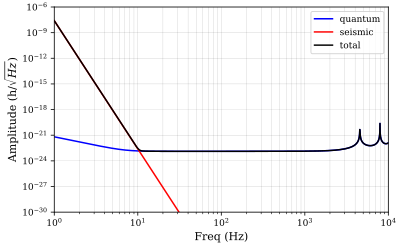

In [157]:
total = np.sqrt(quantum**2 + seismic**2)
plt.loglog(freq, quantum,label='quantum')
plt.loglog(freq, seismic,label='seismic')
plt.loglog(freq, total, label='total')
plt.ylabel('Amplitude (h/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.ylim([1e-30, 1e-6])
plt.legend()
plt.show()